In [1]:
import numpy as np
import nibabel as nib
import glob
import os
import sys
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf
from tensorflow.keras.losses import Loss
import segmentation_models_3D as sm
# segmentation_models = '/exp1/experiment1Softmax/segmentation_models/'

2024-03-11 18:16:08.984437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [2]:
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from tensorflow.keras.backend import clear_session
clear_session()

In [3]:
TRAIN_DATASET_PATH = '/data'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

sample_filename = '/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_FLAIR.nii'
sample_filename2 = '/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_T1.nii'
sample_filename3 = '/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_T2.nii'
sample_filename4 = '/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_T1c.nii'
sample_filename_mask = '/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_tumor_segmentation.nii'

test_image_flair=nib.load(sample_filename).get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
# test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load('/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_T1.nii').get_fdata()
# test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load('/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_T1c.nii').get_fdata()
# test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load('/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_T2.nii').get_fdata()
# test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load('/data/UCSF-PDGM-0014_nifti/UCSF-PDGM-0014_tumor_segmentation.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

2563.422310464084
[0 1 2 4]
[0 1 2 3]


In [4]:
test_mask.shape

(240, 240, 155)

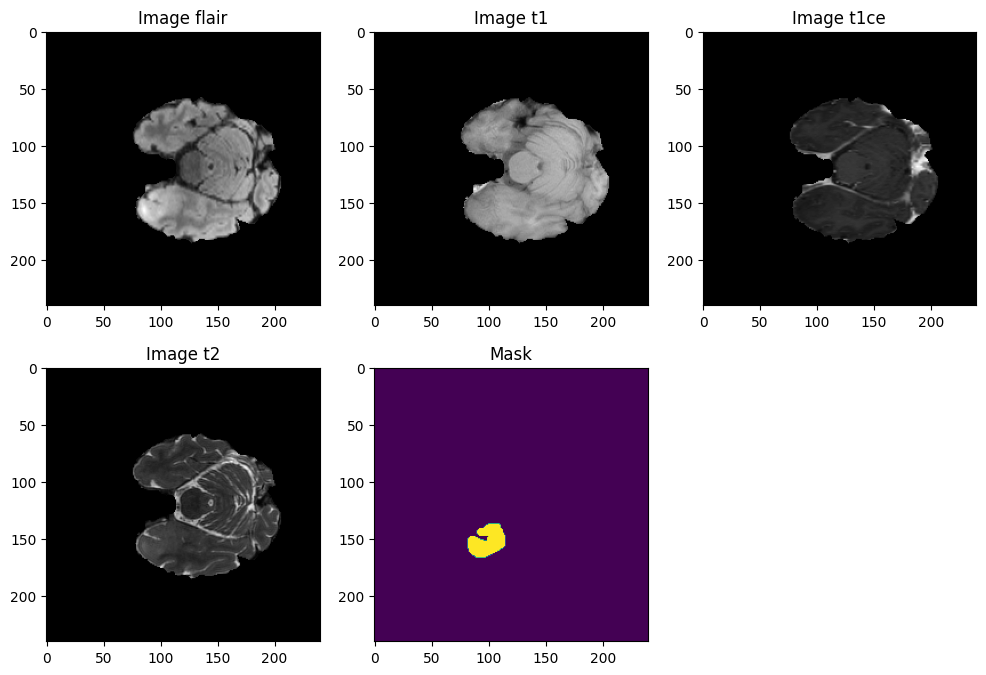

In [5]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

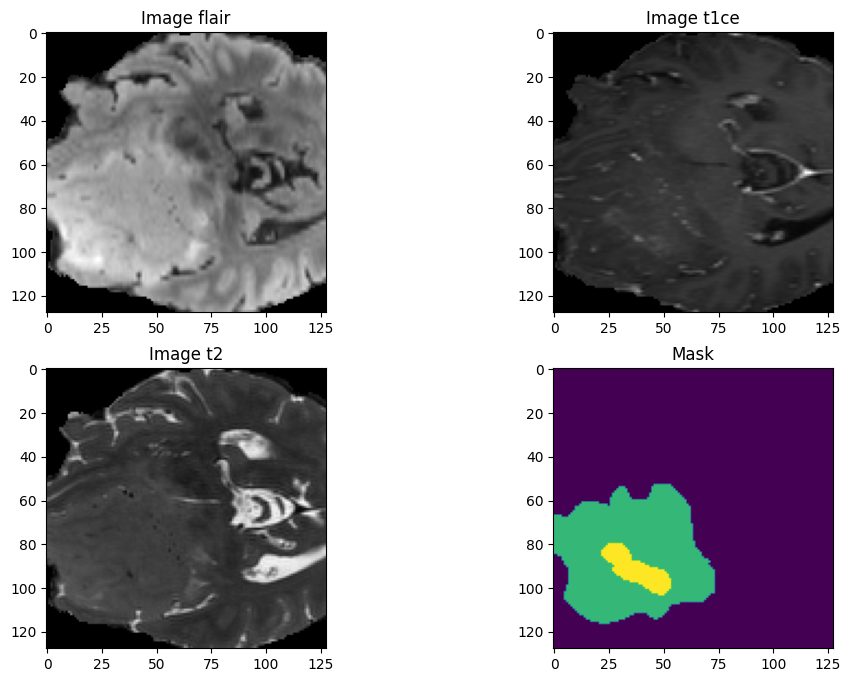

In [6]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [7]:
import os
import random

# Directory containing your data
data_directory = '/data'

# Exclude the specific path you want to skip
excluded_path = '/data/UCSF-PDGM-0541_nifti'
excluded_dirname = os.path.basename(excluded_path)
if excluded_path in data_directory:
    data_directory = data_directory.replace(excluded_path, '')

# List all files in the directory
all_files = os.listdir(data_directory)

# Exclude the specific path you want to skip
# excluded_path = '/data/UCSF-PDGM-0541_nifti'
# if excluded_path in all_files:
#     all_files.remove(excluded_path)

# Shuffle the list of files
random.shuffle(all_files)

# Define the number of files for training and validation
num_train_files = 400

# Split the shuffled list into training and validation sets
train_files = all_files[:num_train_files]
val_files = all_files[num_train_files:]

# Define the paths for training and validation datasets
TRAIN_DATASET_PATH = [os.path.join(data_directory, file) for file in train_files]
VAL_DATASET_PATH = [os.path.join(data_directory, file) for file in val_files]

# Print the first few file paths for verification
print("Training Dataset Paths:")
print(TRAIN_DATASET_PATH[:5])  # Print the first 5 paths
print("\nValidation Dataset Paths:")
print(VAL_DATASET_PATH[:5])    # Print the first 5 paths

Training Dataset Paths:
['/data/UCSF-PDGM-0507_nifti', '/data/UCSF-PDGM-0092_nifti', '/data/UCSF-PDGM-0486_nifti', '/data/UCSF-PDGM-0021_nifti', '/data/UCSF-PDGM-0095_nifti']

Validation Dataset Paths:
['/data/UCSF-PDGM-0091_nifti', '/data/UCSF-PDGM-0151_nifti', '/data/UCSF-PDGM-0372_nifti', '/data/UCSF-PDGM-0484_nifti', '/data/UCSF-PDGM-0464_nifti']


In [8]:
# # List files within the directory associated with the ID
# if ID in train_files:
#     id_directory = os.path.join(data_directory, ID)
#     files = os.listdir(id_directory)

#     # Load NIfTI files for the specified ID
#     if len(files) == 23:
#         _t1 = nib.load(os.path.join(id_directory, files[11])).get_fdata()
#         _flair = nib.load(os.path.join(id_directory, files[15])).get_fdata()
#         _t1ce = nib.load(os.path.join(id_directory, files[20])).get_fdata()
#         _t2 = nib.load(os.path.join(id_directory, files[19])).get_fdata()
#         _mask = nib.load(os.path.join(id_directory, files[9])).get_fdata()

#     else:
#         print(f"Expected 23 files for ID '{ID}', but found {len(files)} files.")
# else:
#     print(f"ID '{ID}' not found in the training set.") 


In [9]:
# # List files within the directory associated with the ID
# if ID in val_files:
#     id_directory = os.path.join(data_directory, ID)
#     files = os.listdir(id_directory)

#     # Load NIfTI files for the specified ID
#     if len(files) == 23:
#         _val_t1 = nib.load(os.path.join(id_directory, files[11])).get_fdata()
#         _val_flair = nib.load(os.path.join(id_directory, files[15])).get_fdata()
#         _val_t1ce = nib.load(os.path.join(id_directory, files[20])).get_fdata()
#         _val_t2 = nib.load(os.path.join(id_directory, files[19])).get_fdata()
#         _val_mask = nib.load(os.path.join(id_directory, files[9])).get_fdata()

#     else:
#         print(f"Expected 23 files for ID '{ID}', but found {len(files)} files.")
# else:
#     print(f"ID '{ID}' not found in the training set.") 

In [10]:
train_t2_list = []
train_t1ce_list = []
train_flair_list = []
train_mask_list = []

# Iterate through all directories in TRAIN_DATASET_PATH
for directory in TRAIN_DATASET_PATH:
    # Extract the base directory name, removing '_nifti' if it is part of the directory name
    base_directory_name = os.path.basename(directory)
    
    # Assuming the ID is correctly represented in the directory name without '_nifti'
    ID = base_directory_name.replace('_nifti', '')

    # Construct file paths without '_nifti' in the filename part
    t2_path = glob.glob(os.path.join(directory, f'{ID}_T2.nii'))
    t1ce_path = glob.glob(os.path.join(directory, f'{ID}_T1c.nii'))
    flair_path = glob.glob(os.path.join(directory, f'{ID}_FLAIR.nii'))
    mask_path = glob.glob(os.path.join(directory, f'{ID}_tumor_segmentation.nii'))

    # Check if all modalities are present for the ID and add them at the same index
    if t2_path and t1ce_path and flair_path and mask_path:
        train_t2_list.append(t2_path[0])  
        train_t1ce_list.append(t1ce_path[0])
        train_flair_list.append(flair_path[0])
        train_mask_list.append(mask_path[0])

In [11]:
# To check and print if all files at a specific index are from the same ID
index_to_check = 0  # Example index
if index_to_check < len(train_t2_list):
    print(f"Files at index {index_to_check}:")
    print(f"T2: {train_t2_list[index_to_check]}")
    print(f"T1ce: {train_t1ce_list[index_to_check]}")
    print(f"FLAIR: {train_flair_list[index_to_check]}")
    print(f"Mask: {train_mask_list[index_to_check]}")
else:
    print("Index is out of range.")

Files at index 0:
T2: /data/UCSF-PDGM-0507_nifti/UCSF-PDGM-0507_T2.nii
T1ce: /data/UCSF-PDGM-0507_nifti/UCSF-PDGM-0507_T1c.nii
FLAIR: /data/UCSF-PDGM-0507_nifti/UCSF-PDGM-0507_FLAIR.nii
Mask: /data/UCSF-PDGM-0507_nifti/UCSF-PDGM-0507_tumor_segmentation.nii


In [12]:
import os
import glob

# Initialize lists for different types of files
val_t2_list = []
val_t1ce_list = []
val_flair_list = []
val_mask_list = []

# Iterate through all directories in TRAIN_DATASET_PATH
for directory in VAL_DATASET_PATH:
    # Extract the base directory name, removing '_nifti' if it is part of the directory name
    base_directory_name = os.path.basename(directory)
    
    # Assuming the ID is correctly represented in the directory name without '_nifti'
    ID = base_directory_name.replace('_nifti', '')

    # Construct file paths without '_nifti' in the filename part
    t2_path = glob.glob(os.path.join(directory, f'{ID}_T2.nii'))
    t1ce_path = glob.glob(os.path.join(directory, f'{ID}_T1c.nii'))
    flair_path = glob.glob(os.path.join(directory, f'{ID}_FLAIR.nii'))
    mask_path = glob.glob(os.path.join(directory, f'{ID}_tumor_segmentation.nii'))

    # Check if all modalities are present for the ID and add them at the same index
    if t2_path and t1ce_path and flair_path and mask_path:
        val_t2_list.append(t2_path[0])  
        val_t1ce_list.append(t1ce_path[0])
        val_flair_list.append(flair_path[0])
        val_mask_list.append(mask_path[0])

# t2_list now contains all T2 files
# print("T2 List:")
# print(val_t2_list)

In [13]:
len(val_t1ce_list)

100

In [14]:
index_to_check = 0  # Example index
if index_to_check < len(val_t2_list):
    print(f"Files at index {index_to_check}:")
    print(f"T2: {val_t2_list[index_to_check]}")
    print(f"T1ce: {val_t1ce_list[index_to_check]}")
    print(f"FLAIR: {val_flair_list[index_to_check]}")
    print(f"Mask: {val_mask_list[index_to_check]}")
else:
    print("Index is out of range.")

Files at index 0:
T2: /data/UCSF-PDGM-0091_nifti/UCSF-PDGM-0091_T2.nii
T1ce: /data/UCSF-PDGM-0091_nifti/UCSF-PDGM-0091_T1c.nii
FLAIR: /data/UCSF-PDGM-0091_nifti/UCSF-PDGM-0091_FLAIR.nii
Mask: /data/UCSF-PDGM-0091_nifti/UCSF-PDGM-0091_tumor_segmentation.nii


In [15]:
# images_dir = 'new_model/experiment1Softmax/images'
# masks_dir = 'new_model/experiment1Softmax/masks'

images_dir = '/exp1/experiment1Softmax/images'
masks_dir = '/exp1/experiment1Softmax/masks'

# Ensure the directories exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

In [16]:
# images_dir = 'new_model/experiment1Softmax/images'
# masks_dir = 'new_model/experiment1Softmax/masks'

images_dir = '/exp1/experiment1Softmax/val/images'
masks_dir = '/exp1/experiment1Softmax/val/masks'

# Ensure the directories exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

In [17]:
models = '/exp1/savedModels'
# masks_dir = '/exp1/new_model/experiment1Softmax/val/masks'

# Ensure the directories exist
os.makedirs(models, exist_ok=True)
# os.makedirs(masks_dir, exist_ok=True)

In [18]:
# for img in range(len(train_t2_list)):  # Using t2_list as all lists are of the same size
#     print("Now preparing image and masks number: ", img)

#     # Load and normalize T2 images
# #     print(train_t2_list[img])
#     temp_image_t2 = nib.load(train_t2_list[img]).get_fdata()
#     temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
# #     unique_values = np.unique(temp_image_t2)
# #     print(unique_values)

#     # Load and normalize T1ce images
# #     print(train_t1ce_list[img])
#     temp_image_t1ce = nib.load(train_t1ce_list[img]).get_fdata()
#     temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

#     # Load and normalize FLAIR images
# #     print(train_flair_list[img])
#     temp_image_flair = nib.load(train_flair_list[img]).get_fdata()
#     temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

#     # Load masks and adjust values
# #     print(train_mask_list[img])
#     temp_mask = nib.load(train_mask_list[img]).get_fdata()
#     temp_mask = temp_mask.astype(np.uint8)
    
#     temp_mask[temp_mask == 4] = 3  # Reassign mask values 4 to 3
#     print("here")
#     unique_values = np.unique(temp_mask)
#     print(unique_values)

#     # Combine images along a new dimension
#     temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
#     #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#     #cropping x, y, and z
#     temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
#     temp_mask = temp_mask[56:184, 56:184, 13:141]
    
#     val, counts = np.unique(temp_mask, return_counts=True)
    
#     if (1 - (counts[0]/counts.sum())) > 0.0001:  # At least 1% useful volume with labels that are not 0
#         print("Save Me")
#         temp_mask = to_categorical(temp_mask, num_classes=4)
#         np.save('/exp1/experiment1Softmax/images/image_'+str(img)+'.npy', temp_combined_images)
#         np.save('/exp1/experiment1Softmax/masks/mask_'+str(img)+'.npy', temp_mask)
#     else:
#         print("I am useless")


In [19]:
# for img in range(len(val_t2_list)):  # Using t2_list as all lists are of the same size
#     print("Now preparing image and masks number: ", img)

#     # Load and normalize T2 images
# #     print(train_t2_list[img])
#     temp_image_t2 = nib.load(val_t2_list[img]).get_fdata()
# #     temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
#     unique_values = np.unique(temp_image_t2)
# #     print(unique_values)

#     # Load and normalize T1ce images
#     temp_image_t1ce = nib.load(val_t1ce_list[img]).get_fdata()
# #     temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

#     # Load and normalize FLAIR images
#     temp_image_flair = nib.load(val_flair_list[img]).get_fdata()
# #     temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

#     # Load masks and adjust values
#     temp_mask = nib.load(val_mask_list[img]).get_fdata()
#     temp_mask = temp_mask.astype(np.uint8)
    
#     temp_mask[temp_mask == 4] = 3  # Reassign mask values 4 to 3
#     print("here")
#     unique_values = np.unique(temp_mask)
#     print(unique_values)

#     # Combine images along a new dimension
#     temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
#     #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#     #cropping x, y, and z
#     temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
#     temp_mask = temp_mask[56:184, 56:184, 13:141]
    
#     val, counts = np.unique(temp_mask, return_counts=True)
    
#     if (1 - (counts[0]/counts.sum())) > 0.0001:  # At least 1% useful volume with labels that are not 0
#         print("Save Me")
#         temp_mask = to_categorical(temp_mask, num_classes=4)
#         np.save('/exp1/experiment1Softmax/val/images/image_'+str(img)+'.npy', temp_combined_images)
#         np.save('/exp1/experiment1Softmax/val/masks/mask_'+str(img)+'.npy', temp_mask)
#     else:
#         print("I am useless")


In [20]:
# pip install split-folders


In [21]:
def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:    
        if image_name.endswith('.npy'):
            image_path = os.path.join(img_dir, image_name)
            image = np.load(image_path)
            images.append(image)
    return np.array(images)

In [22]:
# import splitfolders  # or import split_folders

# input_folder = './BraTS2020_TrainingData/input_data_3channels/'
# output_folder = './BraTS2020_TrainingData/input_data_128/'
# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

In [23]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)

    while True:  # Generator loop
        for batch_start in range(0, L, batch_size):
            limit = min(batch_start + batch_size, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X, Y)  # Yielding a tuple with two elements

In [24]:
from matplotlib import pyplot as plt
import random

train_img_dir = "/exp1/experiment1Softmax/images/"
train_mask_dir = "/exp1/experiment1Softmax/masks/"
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))


batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

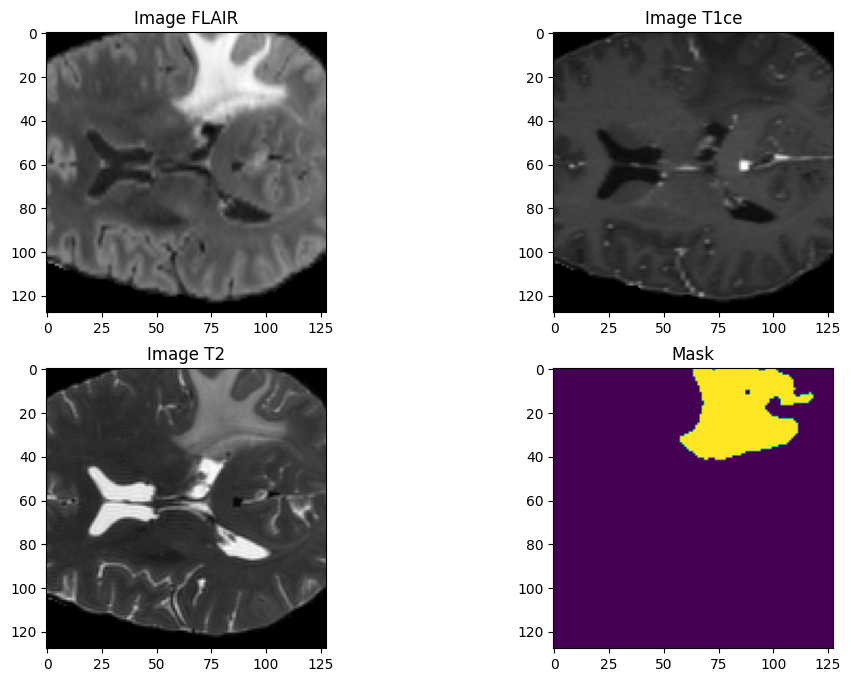

In [25]:
# Assuming `train_img_datagen` is already defined and initiated as per previous discussions
img, msk = next(train_img_datagen)  # Fetch the next batch of images and masks

# Randomly select an image and its corresponding mask from the batch
img_num = random.randint(0, img.shape[0]-1)

test_img = img[img_num]
test_mask = msk[img_num]
# Assuming the mask is one-hot encoded and needs to be converted to categorical labels
test_mask = np.argmax(test_mask, axis=3)

# Randomly select a slice to display, if 3D data
n_slice = random.randint(0, test_mask.shape[2] - 1)

plt.figure(figsize=(12, 8))

# Plotting the randomly selected slice from the image and mask
plt.subplot(221)
plt.imshow(test_img[:, :, n_slice, 0], cmap='gray')  # Assuming channel 0 is FLAIR
plt.title('Image FLAIR')

plt.subplot(222)
plt.imshow(test_img[:, :, n_slice, 1], cmap='gray')  # Assuming channel 1 is T1ce
plt.title('Image T1ce')

plt.subplot(223)
plt.imshow(test_img[:, :, n_slice, 2], cmap='gray')  # Assuming channel 2 is T2
plt.title('Image T2')

plt.subplot(224)
plt.imshow(test_mask[:, :, n_slice])  # Display the mask
plt.title('Mask')

plt.show()

In [26]:
# pip install imageloader

In [27]:
import os
import numpy as np
#import imageloader
#from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

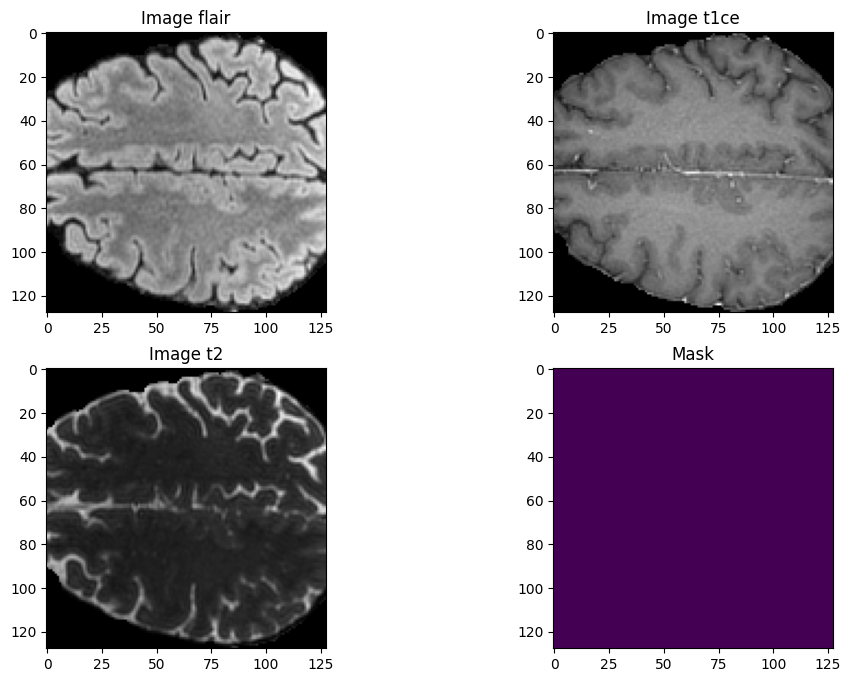

In [28]:
train_img_dir = "/exp1/experiment1Softmax/images/"
train_mask_dir = "/exp1/experiment1Softmax/masks/"

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [29]:
import pandas as pd
columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)

train_mask_dir = "/exp1/experiment1Softmax/masks/"
train_mask_list = sorted(glob.glob(os.path.join(train_mask_dir, '*.npy')))

for img_path in train_mask_list:
    temp_image = np.load(img_path)
    temp_image = np.argmax(temp_image, axis=0)  # Assuming the mask has shape (height, width, channels) and axis=3 is incorrect.
    val, counts = np.unique(temp_image, return_counts=True)
    
    # Ensure counts are matched to the correct columns based on `val`
    counts_dict = {str(v): counts[i] for i, v in enumerate(val) if str(v) in columns}
    
    # Fill missing columns with 0 counts
    for col in columns:
        if col not in counts_dict:
            counts_dict[col] = 0
    
    df = df.append(counts_dict, ignore_index=True)

/tmp/ipykernel_34993/3145929781.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/3145929781.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/3145929781.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/3145929781.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/3145929781.py:21: FutureWarning: The frame.append method is deprecated and will be removed from

In [30]:
# Define the column names for the DataFrame
columns = ['0', '1', '2', '3']
# Initialize an empty DataFrame with these columns
df = pd.DataFrame(columns=columns)

# Define the directory containing your mask files
val_mask_dir = '/exp1/experiment1Softmax/val/masks/'
# Sort the list of mask file paths
val_mask_list = sorted(glob.glob(os.path.join(val_mask_dir, '*.npy')))

# Iterate through each sorted mask file
for img_path in val_mask_list:
    # Load the mask using numpy
    temp_image = np.load(img_path)
    # Apply argmax to convert one-hot encoding to class labels, assuming the last axis is channels
    temp_image = np.argmax(temp_image, axis=3)
    # Calculate the counts of each unique value in the mask
    val, counts = np.unique(temp_image, return_counts=True)
    
    # Create a dictionary to map the column names to their corresponding counts
    counts_dict = {str(v): counts[i] for i, v in enumerate(val) if str(v) in columns}
    
    # Fill in zeros for any missing columns to ensure consistency across all rows
    for col in columns:
        if col not in counts_dict:
            counts_dict[col] = 0
    
    # Append the counts dictionary as a new row in the DataFrame
    df = df.append(counts_dict, ignore_index=True)

/tmp/ipykernel_34993/89085111.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/89085111.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/89085111.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/89085111.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(counts_dict, ignore_index=True)
/tmp/ipykernel_34993/89085111.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [31]:
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

In [32]:
train_img_dir = "/exp1/experiment1Softmax/images/"
train_mask_dir = "/exp1/experiment1Softmax/masks/"

val_img_dir = "/exp1/experiment1Softmax/val/images/"
val_mask_dir = "/exp1/experiment1Softmax/val/masks/"

# Retrieve and sort the list of training images and masks
train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

# Retrieve and sort the list of validation images and masks
val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

In [33]:
# Define a function to extract the sort key (e.g., ID) from the file name
def extract_sort_key(filename):
    # This is an example; adjust the slicing as per your file naming convention
    return filename.split('_')[0]

# Sort the training image and mask lists
train_img_list = sorted(train_img_list, key=extract_sort_key)
train_mask_list = sorted(train_mask_list, key=extract_sort_key)

# Sort the validation image and mask lists
val_img_list = sorted(val_img_list, key=extract_sort_key)
val_mask_list = sorted(val_mask_list, key=extract_sort_key)

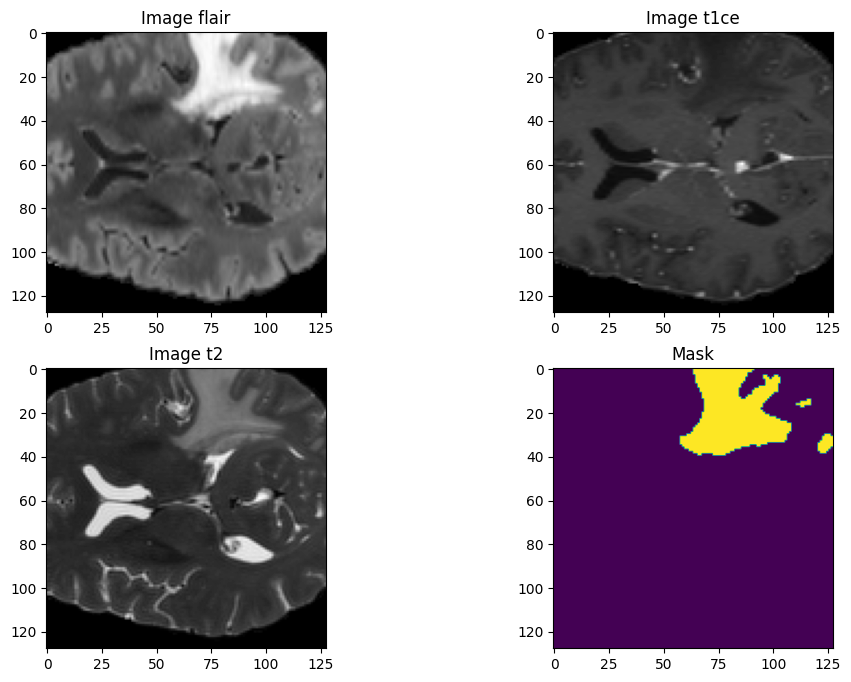

In [34]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

# train_img_datagen.

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [35]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [36]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [37]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Use TensorFlow Keras


In [38]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
from tensorflow.keras.backend import epsilon
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

def recall_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    true_positives = tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    possible_positives = tf.reduce_sum(y_true, axis=(0, 1, 2))
    
    recall = true_positives / (possible_positives + epsilon())
    recall_loss_value = 1 - recall
    
    return tf.reduce_sum(recall_loss_value)

def enhanced_recall_loss(y_true, y_pred):
    gt_enhanced = y_true[:,:,:,:,3]
    pred_enhanced = y_pred[:,:,:,:,3]
    
    return recall_loss(gt_enhanced, pred_enhanced)

def complete_recall_loss(y_true, y_pred):
    gt_combined = tf.reduce_sum(y_true[:,:,:,:,1:4], axis=-1)
    pred_combined = tf.reduce_sum(y_pred[:,:,:,:,1:4], axis=-1)
    
    return recall_loss(gt_combined, pred_combined)

def core_recall_loss(y_true, y_pred):
    # Creating indices for core (necrotic and enhancing)
    indices_core = tf.constant([1, 3])
    
    # Gather the core classes based on the indices
    gt_core = tf.reduce_sum(tf.gather(y_true, indices_core, axis=-1), axis=-1)
    pred_core = tf.reduce_sum(tf.gather(y_pred, indices_core, axis=-1), axis=-1)
    
    return recall_loss(gt_core, pred_core)

In [39]:
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',  # or NON-ENHANCING tumor CORE
    2: 'EDEMA',
    3: 'ENHANCING'  # original 4 -> converted into 3 later
}

In [40]:
batch_size = 8
depth = 128
height = 128
width = 128
num_classes = 4

In [42]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [79]:
# !pip install ctranslate2==4.0.0
# !pip install OpenNMT-tf

In [44]:
model = simple_unet_model(128, 128, 128, 3, 4)
model.compile(loss=total_loss, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
print(model.input_shape)
print(model.output_shape)

import keras.backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

batch_size = 8

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

# csv_logger = CSVLogger('dice_loss.log', separator=',', append=False)


# callbacks = [
# #     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
# #                               patience=2, verbose=1, mode='auto'),
#       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.01, verbose=1),
# #  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
# #                             verbose=1, save_best_only=True, save_weights_only = True),
#         csv_logger
#     ]

# history=model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=35,
#           verbose=1,
#           callbacks = callbacks,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )
# model.save("custom_dice_loss.h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d_8 (Conv3D)           (None, 128, 128, 128, 16)    1312      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 128, 128, 128, 16)    64        ['conv3d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling3d_3 (MaxPoolin  (None, 64, 64, 64, 16)       0         ['batch_normalization_7[

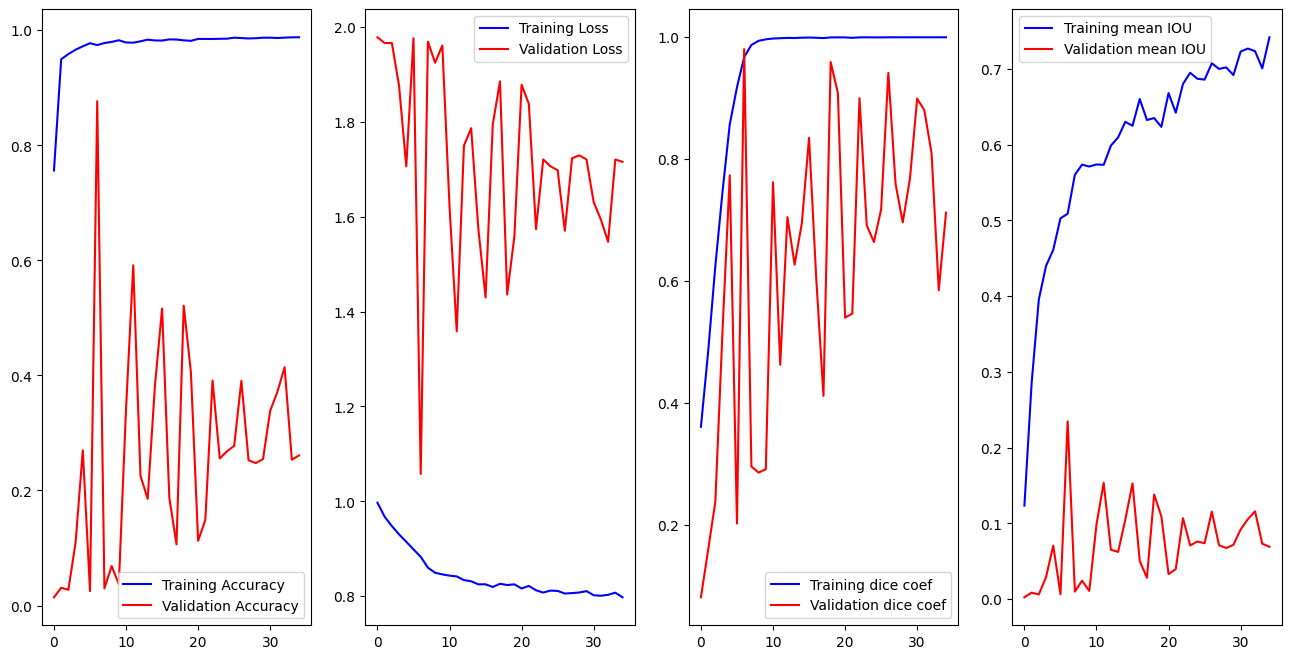

In [46]:
############ load trained model ################
model = keras.models.load_model('custom_dice_loss.h5', 
                                   custom_objects={ 'accuracy' : sm.metrics.IOUScore(threshold=0.5),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('dice_loss.log', sep=',', engine='python')

hist=history

# hist['iou_score']

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['iou_score'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_iou_score'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [49]:
import numpy as np
from keras.models import load_model
import segmentation_models_3D as sm

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = load_model('custom_dice_loss.h5', compile=False)

# Compile the model with the required optimizer, loss, and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=total_loss,  
    metrics=[
        sm.metrics.IOUScore(threshold=0.5),  
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Now all set to continue the training process.
history2 = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=1,
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
)

2024-03-11 18:28:10.557626: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10871635968 exceeds 10% of free system memory.
2024-03-11 18:28:10.557758: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10871635968 exceeds 10% of free system memory.
2024-03-11 18:28:42.373415: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2717908992 exceeds 10% of free system memory.
2024-03-11 18:28:42.374350: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2717908992 exceeds 10% of free system memory.


 1/50 [..............................] - ETA: 50:50 - loss: 0.7851 - iou_score: 0.7949 - dice_coef: 1.0000 - precision: 0.9877 - sensitivity: 0.9875 - specificity: 0.9959 - dice_coef_necrotic: 1.0000 - dice_coef_edema: 1.0000 - dice_coef_enhancing: 1.0000

2024-03-11 18:29:04.340915: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10871635968 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [56]:

######## custom dice loss
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=total_loss,  
    metrics=[
        sm.metrics.IOUScore(threshold=0.5),  
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

results = model.evaluate(
    test_img_datagen,
    steps=steps_per_epoch,
    verbose=1
)

metrics_names = ['loss', 'iou_score', 'dice_coef', 'precision', 'sensitivity', 'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

# Print the results
for metric, value in zip(metrics_names, results):
    print(f"{metric}: {value}")

50/50 [==============================] - 251s 5s/step - loss: 1.6892 - iou_score: 0.0877 - dice_coef: 0.8406 - precision: 0.2835 - sensitivity: 0.2835 - specificity: 0.7612 - dice_coef_necrotic: 0.8429 - dice_coef_edema: 0.8324 - dice_coef_enhancing: 0.8065
loss: 1.6891833543777466
iou_score: 0.08767905086278915
dice_coef: 0.840615451335907
precision: 0.28348249197006226
sensitivity: 0.2834785282611847
specificity: 0.7611647844314575
dice_coef_necrotic: 0.8429096341133118
dice_coef_edema: 0.832407534122467
dice_coef_enhancing: 0.8065426349639893


In [57]:
#######analysis of the trained models
import numpy as np
from keras.models import load_model
import segmentation_models_3D as sm

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = load_model('hybrid_loss_1.h5', compile=False)

######## custom dice loss
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=total_loss,  
    metrics=[
        sm.metrics.IOUScore(threshold=0.5),  
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

results = model.evaluate(
    test_img_datagen,
    steps=steps_per_epoch,
    verbose=1
)

metrics_names = ['loss', 'iou_score', 'dice_coef', 'precision', 'sensitivity', 'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

# Print the results
for metric, value in zip(metrics_names, results):
    print(f"{metric}: {value}")

50/50 [==============================] - 247s 5s/step - loss: 1.7131 - iou_score: 0.0787 - dice_coef: 0.8600 - precision: 0.2616 - sensitivity: 0.2616 - specificity: 0.7539 - dice_coef_necrotic: 0.9140 - dice_coef_edema: 0.8957 - dice_coef_enhancing: 0.9054
loss: 1.713132619857788
iou_score: 0.0787430927157402
dice_coef: 0.8599694967269897
precision: 0.26156315207481384
sensitivity: 0.2615557610988617
specificity: 0.7538620829582214
dice_coef_necrotic: 0.9139621257781982
dice_coef_edema: 0.8957231044769287
dice_coef_enhancing: 0.9054151773452759


In [58]:
import numpy as np
from keras.models import load_model
import segmentation_models_3D as sm

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = load_model('hybrid_loss_2.h5', compile=False)

######## custom dice loss
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=total_loss,  
    metrics=[
        sm.metrics.IOUScore(threshold=0.5),  
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

results = model.evaluate(
    test_img_datagen,
    steps=steps_per_epoch,
    verbose=1
)

metrics_names = ['loss', 'iou_score', 'dice_coef', 'precision', 'sensitivity', 'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

# Print the results
for metric, value in zip(metrics_names, results):
    print(f"{metric}: {value}")

50/50 [==============================] - 256s 5s/step - loss: 1.9364 - iou_score: 0.0146 - dice_coef: 0.3887 - precision: 0.0552 - sensitivity: 0.0552 - specificity: 0.6855 - dice_coef_necrotic: 0.3827 - dice_coef_edema: 0.3740 - dice_coef_enhancing: 0.3611
loss: 1.9363871812820435
iou_score: 0.014568248763680458
dice_coef: 0.38869014382362366
precision: 0.05523353070020676
sensitivity: 0.055164288729429245
specificity: 0.6854598522186279
dice_coef_necrotic: 0.38272035121917725
dice_coef_edema: 0.37404173612594604
dice_coef_enhancing: 0.3610607087612152


In [ ]:
# test_img_datagen = imageLoader(val_img_dir, val_img_list, 
#                                 val_mask_dir, val_mask_list, batch_size)

# #Verify generator.... In python 3 next() is renamed as __next__()
# test_image_batch, test_mask_batch = test_img_datagen.__next__()

# test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
# test_pred_batch = my_model.predict(test_image_batch)
# test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)


# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss=total_loss,  
#     metrics=[
#         sm.metrics.IOUScore(threshold=0.5),  
#         dice_coef,
#         precision,
#         sensitivity,
#         specificity,
#         dice_coef_necrotic,
#         dice_coef_edema,
#         dice_coef_enhancing
#     ]
# )

# results = model.evaluate(
#     test_img_datagen,
#     steps=steps_per_epoch,
#     verbose=1
# )

# metrics_names = ['loss', 'iou_score', 'dice_coef', 'precision', 'sensitivity', 'specificity', 'dice_coef_necrotic', 'dice_coef_edema', 'dice_coef_enhancing']

# # Print the results
# for metric, value in zip(metrics_names, results):
#     print(f"{metric}: {value}")

In [66]:
#For predictions you do not need to compile the model, so ...
# my_model = load_model('custom_dice_loss.h5', compile=False)
my_model = load_model('hybrid_loss_2.h5', compile=False)

from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

# n_classes = 4
# IOU_keras = MeanIoU(num_classes=n_classes)  
# IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())


# dice_coefficient_value = dice_coef(test_mask_batch, test_pred_batch)
# precision_value = precision(test_mask_batch, test_pred_batch)
# sensitivity_value = sensitivity(test_mask_batch, test_pred_batch)
# specificity_value = specificity(test_mask_batch, test_pred_batch)
# dice_coef_necrotic_value = dice_coef_necrotic(test_mask_batch, test_pred_batch)
# dice_coef_edema_value = dice_coef_edema(test_mask_batch, test_pred_batch)
# dice_coef_enhancing_value = dice_coef_enhancing(test_mask_batch, test_pred_batch)

# print("Dice Coefficient =", dice_coefficient_value.numpy())
# print("Precision =", precision_value.numpy())
# print("Sensitivity =", sensitivity_value.numpy())
# print("Specificity =", specificity_value.numpy())
# print("Dice Coefficient Necrotic =", dice_coef_necrotic_value.numpy())
# print("Dice Coefficient Edema =", dice_coef_edema_value.numpy())
# print("Dice Coefficient Enhancing =", dice_coef_enhancing_value.numpy())

1/1 [==============================] - 5s 5s/step


In [67]:
# batch_size=8 #Check IoU for a batch of images
# test_img_datagen = imageLoader(val_img_dir, val_img_list, 
#                                 val_mask_dir, val_mask_list, batch_size)

# #Verify generator.... In python 3 next() is renamed as __next__()
# test_image_batch, test_mask_batch = test_img_datagen.__next__()



1/1 [==============================] - 1s 585ms/step
(128, 128, 128)
(128, 128, 128)
[0 1 3]


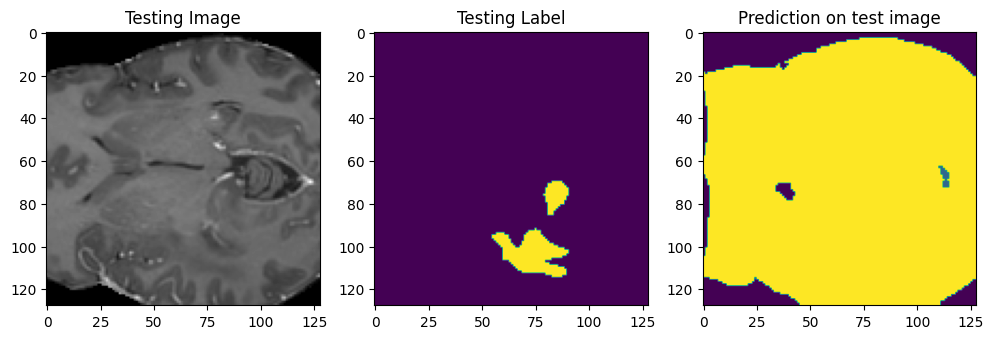

In [68]:
# img_num = 82

test_img = np.load("/exp1/experiment1Softmax/images/image_66.npy")

test_mask = np.load("/exp1/experiment1Softmax/masks/mask_66.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])

1/1 [==============================] - 1s 593ms/step
(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


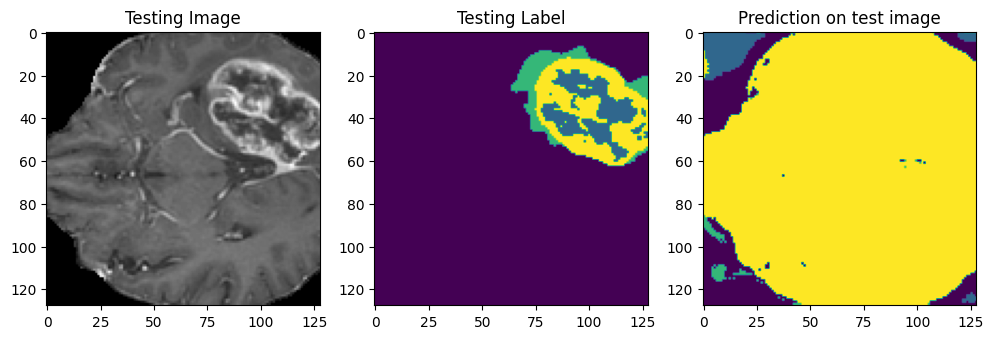

In [62]:
# img_num = 82

test_img = np.load("/exp1/experiment1Softmax/val/images/image_66.npy")

test_mask = np.load("/exp1/experiment1Softmax/val/masks/mask_66.npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])